# Kaggle House Price Prediction

In [1]:
# Import useful libraries and change settings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats
import re
import graphviz
import math
import IPython
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import pdb
from random import random
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import metrics
import sklearn.model_selection as ms
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.cluster import hierarchy as hc
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

if "kaggle" in '\t'.join(sys.path):
    !pip install missingpy
else:
    import sys
    !{sys.executable} -m pip install missingpy
    !{sys.executable} -m pip install xgboost

import xgboost
from missingpy import KNNImputer
#from IPython.display import display
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)

     |████████████████████████████████| 51kB 1.6MB/s 


# Function definitions

In [2]:
# Includes trains_cats, apply_cats and proc_df as direct import from FastAI library

## For data cleansing

def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): 
            df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)
    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

# For model interpretation

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def se(x,y): return (x-y)**2

def mse(x,y): return ((x-y)**2).mean()

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# For visualisation

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))
    
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

def pvalue_sample_differences(dset1, dset2, variable_name):
    if dset1[variable_name].dtype != dset2[variable_name].dtype:
        raise Exception("Choose variables of the same type!")
    elif dset1[variable_name].dtype == "int64" or dset1[variable_name].dtype == "float64":
        return scipy.stats.ks_2samp(dset1[variable_name], dset2[variable_name])[1]
    elif dset1[variable_name].dtype == "object":
        cross_tabl = pd.concat([dset1[variable_name].value_counts(sort = True), dset2[variable_name].value_counts(sort = True)], axis=1, sort=True)
        return scipy.stats.chi2_contingency(cross_tab1)[1]
    else:
        raise Exception("Use numerical or categorical data.")
        
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [3]:
def numericalize2(df, name):
    if not is_numeric_dtype(df[name]):
        df[name] = pd.Categorical(df[name]).codes+1

def fix_missing2(df, split_point, imputation_methodology):
    na_dict = {}
    
    df_temp = df.iloc[:split_point, :]
    
    for name, _ in df.items():
        if is_numeric_dtype(df[name]) and pd.isnull(df[name]).sum():
            df[name+'_NA'] = pd.isnull(df[name]).astype("int64")
            if imputation_methodology == "median":
                filler = df_temp[name].median()
            elif imputation_methodology == "mean":
                filler = df_temp[name].mean()
            elif imputation_methodology == "zero":
                filler = 0
            else:   
                raise Exception("Invalid imputation methodology")
            df[name] = df[name].fillna(filler)
            na_dict[name] = filler
    return na_dict

def fix_missing_alg(df, split_point, imputation_methodology):
    na_dict = {}                
    df_temp = df.iloc[:split_point, :]
    
    if imputation_methodology == "5NN":
        imp = KNNImputer(n_neighbors=5, weights="uniform", col_max_missing = 1, row_max_missing = 1)
    elif imputation_methodology == "KNN":
        imp = KNNImputer(n_neighbors=round(math.sqrt(df.shape[0])), weights="uniform", col_max_missing = 1, row_max_missing = 1)
    elif imputation_methodology == "IterativeImputer":
        imp = IterativeImputer(max_iter=1000, random_state=0)
    else:   
        raise Exception("Invalid imputation methodology")
        
    df_combined_temp = pd.get_dummies(df, dummy_na=True) 
    for variable_name in df_combined_temp.filter(regex = "nan$",axis=1).columns:
        variable_name_suffix = variable_name[0:variable_name.find('_')]
        regex_filter = variable_name_suffix + "$"
        for suffix_varable in df_combined_temp.filter(regex = regex_filter,axis=1).columns:
            df_combined_temp[df_combined_temp[variable_name] == 1, suffix_varable] = np.nan
        df_combined_temp.drop([variable_name], axis=1, inplace=True)
    
    column_names = list(df_combined_temp.columns)
    df_train_temp_filled = imp.fit_transform(df_combined_temp.iloc[:split_point, :].copy())
    
    if df_combined_temp.shape[0] != split_point:
        df_test_temp_filled = imp.transform(df_combined_temp.iloc[split_point:, :].copy())
        df_combined_filled = pd.concat([pd.DataFrame(df_train_temp_filled, columns = column_names), pd.DataFrame(df_test_temp_filled, columns = column_names)])
        df_combined_filled.index = df_combined_temp.index
    else:
        df_combined_filled = pd.DataFrame(df_train_temp_filled, columns = column_names, index = df.index)
        
    for name in ["PropertyType1", "ElectricalType", 'VeneerType', 'VeneerArea', "LotFrontage", "Utilities", "KitchenQual", "Functional", "ZoningClass", "Exterior1", "Exterior2", "SaleType", "GarageAge", "GarageYrBlt", "GarageArea", "GarageCarsCount"]:
        if pd.isnull(df[name]).sum():
            df[name+'_NA'] = pd.isnull(df[name]).astype("int64")
            na_dict[name] = imputation_methodology
            if name == "LotFrontage":
                df[name] = df_combined_filled[name]
            elif name in ["PropertyType1", "ElectricalType", "VeneerType", "Utilities", "KitchenQual", "Functional", "ZoningClass", "Exterior1", "Exterior2", "SaleType"]:
                regex_item = "^" + name
                variable_list = list(df_combined_filled.filter(regex=regex_item,axis=1).columns)
                df[name] = df_combined_filled[variable_list].idxmax(axis=1).str.replace(name + "_", "")         
            elif name == "VeneerArea":
                df_combined_filled.loc[df["VeneerType"] == "None", "VeneerArea"] = 0
                df[name] = df_combined_filled[name]
            elif name in ["GarageAge", "GarageYrBlt", "GarageArea", "GarageCarsCount"]:
                df_combined_filled.loc[df["GarageType"] == "None", name] = df[name].median()
                df[name] = df_combined_filled[name]
    return na_dict

def proc_df2(vars_to_cat, df1, df2 = None, y_fld = "SalePrice", n_validation = None, percentage_validation = None, add_variables = False, 
    imputation_methodology = "median", impute_using = "train", drop_outliers = False, log_size_variables = False, square_variables = False, drop_variables = False):
    """ proc_df2 takes the Ames data set, performs the requested transformations, and 
    changes the df into an entirely numeric dataframe.
    Parameters:
    -----------
    vars_to_cat: Options are "none", "all", and "ordinal." All converts all string variables to categories,
    and "ordinal" converts variables that on inspect seemed to be ordinal to category variables.
    df1: The training data frame that you wish to process.
    df2: The test data that you wish to process.  Note that information used in imputing is entirely generated
    from the training data set (not the validation or test set) unless imputing_using = "all". This option must be None to include a validation set.
    y_fld: Options are "SalePrice" and "PricePerArea."  If "PricePerArea" is used, this variable is generated
    from the data set and SalePrice is dropped.
    n_validation: This must be None if percentage_validation is not None or if df2 is not None. If this
    option equals an integer N, df1 will be split into a train and validation data set, with the number of observations
    in the validation data set being equal to N.
    percentage_validation: This must be None if n_validation is not None or if df2 is not None. If this
    option equals a fraction P, df1 will be split into a train and validation data set, with the proportion
    of observations in the validation set being equal to P.
    add_variables:  If True, various variables are generated. 
    imputation_methodology: Options are "KNN", "IterativeImputer" (MICE), "median", "mean", and "zero".
    impute_using: Options are "train" and "all."  "Train" implies that only data from df1 is used
    to impute, while "all" uses information from df1 and df2 for the imputation process.
    drop_outliers: Options are False, "5SD", "10SD", and "manual."
    log_size_variables: If True, various variables related to the size of the property
    that are non-zero for all observations are logged.
    square_variables: If True, the square of various variables that were found to be
    important in the tree model are added to the data frame.
    drop_variables: Options are False, "minimal", and "comprehensive."  "Minimal" only
    drops variables whose information is entirely captured by the variables that are added,
    while comprehensive drops a larger number of variables, including some that likely include
    additional information.  This option must be False if add_variables if False.
    
    Returns:
    --------
    IF DF2 IS NONE, N_VALIDATION IS NONE, AND PERCENTAGE_VALIDATION IS NONE:
    [x, y, nas]:
        x: x is the transformed version of the entire data set -- all elements will be numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        
    IF DF2 IS NOT NONE, N_VALIDATION IS NOT NONE, OR PERCENTAGE_VALIDATION IS NOT NONE:
    [x_train, y_train, x_valortest, y_valortest, nas]:
        x_train: x is the transformed version of the training portion of the data set.
        y_train: y is the response variable for the training portion of the data set.
        x_valortest: x is the transformed version of the validation/test portion of the data set.
        y_valortest: y is the response variable for the validation/test portion of the data set.  
        **IT LIKELY DOESN'T EXIST FOR TEST DATA SETS.**        
        nas: returns a dictionary of which nas it created, and the associated median.
    """

    # Checking for incompatibilities among types.
    if df2 is not None and (n_validation is not None or percentage_validation is not None):
        raise Exception("Cannot transform two datasets and generate validation data set!")
    if df1.shape[0] == 0 or (df2 is not None and df2.shape[0] == 0):
        raise Exception("Cannot use empty dataframes!")
    if n_validation is not None and n_validation >= df1.shape[0]:
        raise Exception("Cannot have validation dataset be larger or equal in size to total data set!")
    if drop_variables is not False and add_variables is False:
        raise Exception("Don't drop variables (yet) unless you are keeping the information somewhere else!")
    if vars_to_cat == "ordinal" and drop_variables == "comprehensive":
        raise Exception("If you are converting variables to category, you are estimating a tree model and don't need to drop a ton of variables!")

    if drop_outliers == "manual" and vars_to_cat == "none":
        print("Manually Dropping Size Outliers...")
        df1_copy = df1[np.logical_or(df1["AboveGradeAreaSF"] < 5000, pd.isna(df1["AboveGradeAreaSF"]))].copy()
    elif drop_outliers == "5SD" and vars_to_cat == "none":
        print("Dropping 5 SD Outliers...")
        df1_copy = df1[(np.abs(scipy.stats.zscore(df1[["1stFlrSF", "LotArea"]].select_dtypes(include=['float64', "int64"]))) < 5).all(axis=1)].copy()
    elif drop_outliers == "10SD"  and vars_to_cat == "none":
        print("Dropping 10 SD Outliers...")
        df1_copy = df1[(np.abs(scipy.stats.zscore(df1[["1stFlrSF", "LotArea"]].select_dtypes(include=['float64', "int64"]))) < 10).all(axis=1)].copy()
    else:
        df1_copy = df1.copy()
    
    if df2 is not None:
        df2_copy = df2
        split_point = df1_copy.shape[0]
        df_combined = pd.concat([df1_copy, df2_copy])
    elif n_validation is not None:
        split_point = df1_copy.shape[0] - n_validation
        df_combined = df1_copy
    elif percentage_validation is not None:
        split_point = round(df1_copy.shape[0] * (1 - percentage_validation))
        df_combined = df1_copy
    else:
        split_point = df1_copy.shape[0]
        df_combined = df1_copy
        
    if impute_using == "all":
        imputation_split = df_combined.shape[0]
    else:
        imputation_split = split_point
        
    for variable_name in ["FinishedBasementSF1", "FinishedBasementSF2", "UnfinishedBasementSF", "TotalBsmtSF", "BsmtFullBathCount", "BsmtHalfBathCount"]:    
        df_combined.loc[np.logical_and(df_combined["BsmtQual"] == "None", df_combined["BsmtCond"] == "None"), variable_name] = 0

    if imputation_methodology == "KNN" or imputation_methodology == "IterativeImputer":
        na_dict = fix_missing_alg(df_combined, imputation_split, imputation_methodology)

    if add_variables is True:
        df_combined["HouseAge"] = df_combined.YrSold - df_combined.YearBuilt
        df_combined["RemodAge"] = df_combined.YrSold - df_combined.YearLastRemodeled
        df_combined["GarageAge"] = df_combined.YrSold - df_combined.GarageYrBlt
    
        df_combined["Season"] = ""
        df_combined.loc[np.logical_or(np.logical_or(df_combined["MoSold"] == 3, df_combined["MoSold"] == 4), df_combined["MoSold"] == 5), "Season"] = "Spring"
        df_combined.loc[np.logical_or(np.logical_or(df_combined["MoSold"] == 6, df_combined["MoSold"] == 7), df_combined["MoSold"] == 8), "Season"] = "Summer"
        df_combined.loc[np.logical_or(np.logical_or(df_combined["MoSold"] == 9, df_combined["MoSold"] == 10), df_combined["MoSold"] == 11), "Season"] = "Fall"
        df_combined.loc[np.logical_or(np.logical_or(df_combined["MoSold"] == 12, df_combined["MoSold"] == 1), df_combined["MoSold"] == 2), "Season"] = "Winter"
        
        df_combined["Months_from_Start"] = (df_combined["MoSold"] - 1) + 12*(df_combined["YrSold"] - 2006)
        
        df_combined["Residential"] = df_combined["ZoningClass"].isin(["FloatingVillage", "ResHighDens", "ResLowDens", "ResLowDensPark", "ResMedDens"]).astype(int)             
        df_combined["MixedUse"] = df_combined["ZoningClass"].isin(["ResHighDens", "FloatingVillage", "Commercial", "Industrial"]).astype(int)     
        df_combined["LowDensity"] = df_combined["ZoningClass"].isin(["Agriculture", "FloatingVillage", "ResLowDens", "ResLowDensPark"]).astype(int) 

        df_combined["Depression_Price_Flags"] = 0
        df_combined.loc[np.logical_or(np.logical_or(np.logical_or(df_combined["SaleFlags"] == "Abnormal", df_combined["SaleFlags"] == "Family"), df_combined["SaleFlags"] == "Adjoining"), df_combined["SaleType"] == "COD"), "Depression_Price_Flags"] = 1

        df_combined["Warranty"] = df_combined["SaleType"].isin(["WD", "CWD", "VWD"]).astype(int) 
        df_combined["New"] = df_combined["SaleType"].isin(["New"]).astype(int) 
        df_combined["Reg_Contract"] = df_combined["SaleType"].isin(["Con"]).astype(int) 
        df_combined["Irr_Contract"] = df_combined["SaleType"].isin(["ConLw", "ConLI", "ConLD"]).astype(int) 
        df_combined["SaleType_NA"] = df_combined["SaleType"].isna().astype("int64")

        df_combined["Pre_War_Original"] = 0
        df_combined.loc[np.logical_and(df_combined["YearBuilt"] < 1946, df_combined["YearLastRemodeled"] < 1946), "Pre_War_Original"] = 1
        
        df_combined["Pre_War_Remodelled"] = 0
        df_combined.loc[np.logical_and(df_combined["YearBuilt"] < 1946, df_combined["YearLastRemodeled"] >= 1946), "Pre_War_Remodelled"] = 1

        df_combined["Missing_Utilities"] = df_combined["Utilities"].isin(["NoSewer", "NoSewerWater", "OnlyElectric"]).astype(int)
        df_combined["NA_Utilities"] = df_combined["Utilities"].isna().astype("int64")
        
        urban_amenities = ["AdjacentAmenity", "CloseAmenit"]
        rail_amenities = ["CloseNSRail", "CloseEWRail", "AdjacentNSRail", "AdjacentEWRail"]
        street_amenities = ["ArteryStreet", "FeederStreet"]
        
        df_combined["Number_of_Urban_Amenities"] = df_combined.isin(urban_amenities).sum(1) 
        df_combined["Number_of_Rail_Amenities"] = df_combined.isin(rail_amenities).sum(1) 
        df_combined["Number_of_Street_Amenities"] = df_combined.isin(street_amenities).sum(1) 
        
        df_combined["Minor_Defects"] = df_combined["Functional"].isin(["MinorDeduction1", "MinorDeduction2"]).astype(int) 
        df_combined["Moderate_Defects"] = df_combined["Functional"].isin(["ModerateDeduction"]).astype(int) 
        df_combined["Major_Defects"] = df_combined["Functional"].isin(["MajorDeductions1", "MajorDeduction2"]).astype(int) 
        df_combined["Worst_Defects"] = df_combined["Functional"].isin(["SevereDamage", "Salvage"]).astype(int) 
        df_combined["Functional_Missing"] = df_combined["Functional"].isna().astype("int64")
        
        df_combined["TotalHalfBath"] = df_combined["HalfBathCount"] + df_combined["BsmtHalfBathCount"]
        df_combined["TotalFullBath"] = df_combined["FullBathCount"] + df_combined["BsmtFullBathCount"]
        df_combined["TotalBath"] = (0.5*df_combined["TotalHalfBath"]) + df_combined["TotalFullBath"]
        
        df_combined["PorchArea"] = df_combined["WoodDeckSF"] + df_combined["OpenPorchSF"] + df_combined["EnclosedPorchSF"] + df_combined["3SsnPorchSF"] + df_combined["ScreenPorchSF"]
        df_combined['MainPorchType'] = df_combined[['WoodDeckSF','OpenPorchSF', 'EnclosedPorchSF', '3SsnPorchSF', 'ScreenPorchSF']].idxmax(axis=1)

        df_combined["Gas_Heater"] = df_combined["HeatingType"].isin(["GasAir", "GasWater"]).astype(int) 
        df_combined["Steam_Heater"] = df_combined["HeatingType"].isin(["OtherWater"]).astype(int) 
        df_combined["Other_Heater"] =  df_combined["HeatingType"].isin(["Floor", "Grav", "Other_Heater"]).astype(int) 
        
        df_combined["FenceType"] = "None"
        df_combined.loc[np.logical_or(df_combined["FenceQual"] == "GoodPrivacy", df_combined["FenceQual"] == "MinimumPrivacy"), "FenceType"] = "Privacy"
        df_combined.loc[np.logical_or(df_combined["FenceQual"] == "GoodWood", df_combined["FenceQual"] == "MinimumWoodWire"), "FenceType"] = "Wood"

        df_combined["FenceQuality"] = "None"
        df_combined.loc[np.logical_or(df_combined["FenceQual"] == "GoodPrivacy", df_combined["FenceQual"] == "GoodWood"), "FenceQuality"] = "Good"
        df_combined.loc[np.logical_or(df_combined["FenceQual"] == "MinimumWoodWire", df_combined["FenceQual"] == "MinimumPrivacy"), "FenceQuality"] = "Fair"
        
        df_combined["All_Paved"] = 1
        df_combined.loc[df_combined["StreetMaterial"] == "Gravel", "All_Paved"] = 0
        df_combined.loc[~(df_combined["AlleyMaterial"] == "Paved"), "All_Paved"] = 0
        df_combined.loc[~(df_combined["PavedDriveType"] == "Paved"), "All_Paved"] = 0
        
        df_combined['Excellent_count'] = df_combined.isin(["Excellent"]).sum(1) 
        df_combined['Good_count'] = df_combined.isin(["Good"]).sum(1) 
        df_combined['Average_count'] = df_combined.isin(["Average"]).sum(1) 
        df_combined['Fair_count'] = df_combined.isin(["Fair"]).sum(1) 
        df_combined['Poor_count'] = df_combined.isin(["Poor"]).sum(1) 
        df_combined['Total_Rated'] = df_combined['Excellent_count'] + df_combined['Good_count'] + df_combined['Average_count'] + df_combined['Fair_count'] + df_combined['Poor_count']
        
        df_combined['Average_Score'] = (9*df_combined['Excellent_count'] + 7*df_combined['Good_count'] + 5*df_combined['Average_count'] + 3*df_combined['Fair_count'] + 2*df_combined['Poor_count']) / df_combined['Total_Rated']
        
        df_combined["Excess_Street_Access"] = df_combined["LotConfig"].isin(["Corner", "Frontage2Sides", "Frontage3Sides"]).astype(int)  
        
        df_combined["Regular_Slope"] = 1
        df_combined.loc[df_combined["LandContour"] != "Level", "Regular_Slope"] = 0
        df_combined.loc[df_combined["LandSlope"] != "Gentle", "Regular_Slope"] = 0
        
        df_combined["Irregular_Shape"] = df_combined["LotShape"].isin(["IR1", "IR2", "IR3"]).astype(int) 
        
        df_combined["Neigh1"] = df_combined["Neighborhood"].isin(["Northridge", "NorthridgeHeights", "StoneBrook"]).astype(int) 
        df_combined["Neigh2"] = df_combined["Neighborhood"].isin(["Timberland", "Veenker", "Somerset", "ClearCreek"]).astype(int) 
        df_combined["Neigh3"] = df_combined["Neighborhood"].isin(["Crawford", "BloomingtonHeights", "Gilbert", "NWAmes"]).astype(int) 
        df_combined["Neigh4"] = df_combined["Neighborhood"].isin(["SawyerWest", "Mitchell", "NorthAmes", "NorthparkVilla"]).astype(int) 
        df_combined["Neigh5"] = df_combined["Neighborhood"].isin(["SWISU", "Bluestem", "Sawyer"]).astype(int) 
        df_combined["Neigh6"] = df_combined["Neighborhood"].isin(["OldTown", "Edwards", "Brookside", "Briardale"]).astype(int) 
        df_combined["Neigh7"] = df_combined["Neighborhood"].isin(["MeadowVillage", "IDOTRR"]).astype(int) 
        
        df_combined["Total_Rooms"] = df_combined["AboveGradeRooms"] + df_combined["FinishedBasementType1"].isin(["GoodLivingQuarters", "AverageLivingQuarters", "BelowAverageLivingQuarters", "RecRoom", "LowQuality"]).astype(int) + df_combined["FinishedBasementType2"].isin(["GoodLivingQuarters", "AverageLivingQuarters", "BelowAverageLivingQuarters", "RecRoom", "LowQuality"]).astype(int)

        df_combined["Total_House_Sqft"] = df_combined["TotalBsmtSF"] + df_combined["AboveGradeAreaSF"]
        df_combined["House_Proportion"] = df_combined["1stFlrSF"]/ df_combined["LotArea"]
        df_combined["House_Proportion_Alt"] = df_combined["Total_House_Sqft"]/ df_combined["LotArea"]
        df_combined["Fin_Bsmt_Sqft"] = df_combined["FinishedBasementSF1"] + df_combined["FinishedBasementSF2"]

        df_combined["Single_Exterior"] = (np.asarray(df_combined.Exterior1) == np.asarray(df_combined.Exterior2)).astype(int) 
        
        df_combined["Duplex"] = 0
        df_combined.loc[np.logical_or(df_combined["PropertyType1"] == "Duplex", df_combined["PropertyType2"] == "Duplex"), "Duplex"] = 1
        df_combined["PUD"] = df_combined["PropertyType1"].isin(["1StoryPlannedDevelopment", "1.5StoryPlannedDevelopment", "2StoryPlannedDevelopment", "MultilevelPlannedDevelopment"]).astype(int) 
        
        df_combined["1Story"] = 0
        df_combined.loc[np.logical_or(np.logical_or(np.logical_or(np.logical_or(df_combined["PropertyType1"] == "1StoryPostWar", df_combined["PropertyType1"] == "1StoryPreWar"), df_combined["PropertyType1"] == "1StoryAttic"), df_combined["PropertyType1"] == "1StoryPlannedDevelopment"), df_combined["HouseStyle"] == "1Story"), "1Story"] = 1
        
        df_combined["1.5UnfStory"] = 0
        df_combined.loc[np.logical_or(df_combined["PropertyType1"] == "1.5StoryUnfinished", df_combined["HouseStyle"] == "1.5Finished"), "1.5UnfStory"] = 1
        df_combined["1.5FinStory"] = 0
        df_combined.loc[np.logical_or(df_combined["PropertyType1"] == "1.5StoryFinished", df_combined["HouseStyle"] == "1.5Finished"), "1.5FinStory"] = 1
        
        df_combined["2Story"] = 0
        df_combined.loc[np.logical_or(np.logical_or(np.logical_or(df_combined["PropertyType1"] == "2StoryPreWar", df_combined["PropertyType1"] == "2StoryPostWar"), df_combined["PropertyType1"] == "2StoryPlannedDevelopment"), df_combined["HouseStyle"] == "2Story"), "2Story"] = 1
        
        df_combined["2.5Story"] = 0
        df_combined.loc[np.logical_or(np.logical_or(df_combined["PropertyType1"] == "2.5Story", df_combined["HouseStyle"] == "2.5Finished"), df_combined["HouseStyle"] == "2.5Unfinished"), "2.5Story"] = 1
        
        df_combined["SplitFoyer"] = 0
        df_combined.loc[np.logical_or(df_combined["PropertyType1"] == "SplitFoyer", df_combined["HouseStyle"] == "SplitFoyer"), "SplitFoyer"] = 1
        
        df_combined["SplitLevel"] = 0
        df_combined.loc[np.logical_or(df_combined["PropertyType1"] == "SplitNoFoyer", df_combined["HouseStyle"] == "SplitLevel"), "SplitLevel"] = 1
        
        df_combined["2FamilyConversion"] = 0
        df_combined.loc[np.logical_or(df_combined["PropertyType1"] == "2FamilyConversion", df_combined["PropertyType2"] == "2FamilyConv"), "2FamilyConversion"] = 1

        df_combined["1Family"] = 0
        df_combined.loc[df_combined["PropertyType2"] == "1Family", "1Family"] = 1

        df_combined["Attic"] = df_combined["PropertyType1"].isin(["1StoryAttic"]).astype(int) 
        df_combined["Townhouse"] = df_combined["PropertyType2"].isin(["Twnhs", "EndTownhouse"]).astype(int) 
        df_combined["PUDMultilevel"] = df_combined["PropertyType1"].isin(["MultilevelPlannedDevelopment"]).astype(int) 
    
        df_combined["Basement_Living_Area"] = (df_combined["FinishedBasementType1"].isin(["GoodLivingQuarters", "AverageLivingQuarters", "BelowAverageLivingQuarters"]).astype(int)*df_combined["FinishedBasementSF1"]) + (df_combined["FinishedBasementType2"].isin(["GoodLivingQuarters", "AverageLivingQuarters", "BelowAverageLivingQuarters"]).astype(int)*df_combined["FinishedBasementSF2"])
        df_combined["Basement_Rec_Area"] = (df_combined["FinishedBasementType1"].isin(["RecRoom"]).astype(int)*df_combined["FinishedBasementSF1"]) + (df_combined["FinishedBasementType2"].isin(["RecRoom"]).astype(int)*df_combined["FinishedBasementSF2"])
        df_combined["Basement_LQ_Area"] = (df_combined["FinishedBasementType1"].isin(["LowQuality"]).astype(int)*df_combined["FinishedBasementSF1"]) + (df_combined["FinishedBasementType2"].isin(["LowQuality"]).astype(int)*df_combined["FinishedBasementSF2"])
                
        for materials in ["AsbestosShingles", "AsphaltShingles", "CommonBrick", "FaceBrick", "CinderBlock", "Cement", "Hardboard", "ImitationStucco", "Metal", "Other", "Plywood", "Stone", "Stucco", "Vinyl", "WoodSiding", "WoodShingles"]:
            variable_name = "Exterior_" + materials + "Proportion"
            df_combined[variable_name] = 0.5*(df_combined["Exterior1"].isin([materials]).astype(int)) + .5*(df_combined["Exterior2"].isin([materials]).astype(int))
            
        df_combined["Exterior_Unknown_Proportion"] = df_combined["Exterior1"].isna().astype("int64")
        
        df_combined["Property_Type_1NA"] = df_combined["PropertyType1"].isna().astype("int64")
        
    if drop_variables is False: 
        drop_variables_list = [] 
    elif drop_variables == "comprehensive":
        drop_variables_list = ["SaleType", "HeatingType", "Functional", "Utilities", "PropertyType1", "HouseStyle", "PropertyType2", "Neighborhood", "LotShape", "LandContour", "LandSlope", "PavedDriveType", "FenceQual", "StreetMaterial", "AlleyMaterial", "PoolQual", "GarageQual", "GarageCond", "FireplaceQual", "BsmtQual", "HeatingCond", "BsmtExposure", "BsmtCond", "ExteriorCond", "ExteriorQual","FenceQual", 'WoodDeckSF','OpenPorchSF', 'EnclosedPorchSF', '3SsnPorchSF', 'ScreenPorchSF', "HalfBathCount", "BsmtHalfBathCount", "FullBathCount", "BsmtFullBathCount", "AlleyMaterial", "LocationAmenity1", "LocationAmenity2", "MoSold", "GarageYrBlt", "YearLastRemodeled", "YearBuilt", "SaleFlags", "Exterior1", "Exterior2"]
    elif drop_variables == "minimal":
        drop_variables_list = ["FenceQual", "Utilities", "PropertyType1", "HouseStyle", "PropertyType2", "Exterior1", "Exterior2"]
    else:
        raise Exception("Invalid drop_variable input: options are False, comprehensive, and minimal.")

    if y_fld != "PricePerArea":               
        y = df_combined[y_fld].values
        drop_variables_list += [y_fld]
    else:
        y = np.log(df_combined.SalePrice/df_combined.LotArea).values
        drop_variables_list += ["SalePrice"]
        
    df_combined.drop(drop_variables_list, axis=1, inplace=True)

    if imputation_methodology != "KNN" and imputation_methodology != "IterativeImputer":
        na_dict = fix_missing2(df_combined, imputation_split, imputation_methodology) 
    
    if vars_to_cat == "ordinal":
        for n in ["LotShape", "LandSlope", "ExteriorQual", "ExteriorCond", "BsmtQual", "BsmtCond", 
                  "BsmtExposure", "FinishedBasementType1", "FinishedBasementType2", "HeatingCond", "KitchenQual",
                  "Functional", "FireplaceQual", "GarageQual", "GarageQual", "GarageCond", "PoolQual"]:
            numericalize2(df_combined, n)
    elif vars_to_cat == "all":
        for n, _ in df_combined.items(): 
            numericalize2(df_combined, n)
    elif vars_to_cat != "none":
        raise Exception("Choose a valid categorization scheme!")
     
    df_combined = pd.get_dummies(df_combined, dummy_na=True)
    
    df_combined.drop(list(df_combined.filter(regex='nan$',axis=1).loc[:, (df_combined == 0).all(axis=0)].columns), axis = 1, inplace = True)
    df_combined.drop(list(df_combined.filter(regex='na$',axis=1).loc[:, (df_combined == 0).all(axis=0)].columns), axis = 1, inplace = True)
    df_combined.drop(list(df_combined.loc[:, (df_combined == 0).all(axis=0)].columns), axis = 1, inplace = True)

    if add_variables == True and drop_variables == "minimal":
        print("Minimally dropping variables.")
        df_combined.drop(["HeatingType_OtherWater", "VeneerArea_NA", "FenceQuality_None", "FenceType_None", "New", "Reg_Contract",
                              "GarageQual_None", "GarageInterior_None", "GarageCond_None", 'BsmtCond_None', 'BsmtExposure_NoBasement', 'Functional_ModerateDeduction', "Functional_SevereDamage",
                              'BsmtQual_None', "FenceType_None", "HeatingType_Floor"], axis = 1, inplace = True, errors = "ignore")
    elif add_variables == True and drop_variables == "comprehensive":
        print("Comprehensively dropping variables.")
        df_combined.drop(["VeneerArea_NA", "FenceQuality_None", 'ZoningClass_C (all)', 'ZoningClass_FloatingVillage', 'ZoningClass_ResHighDens', 'ZoningClass_ResLowDens', 'ZoningClass_ResMedDens', "GarageCarsCount_NA", "GarageInterior_None", "FenceType_None"], axis = 1, inplace = True, errors = "ignore")        
    elif drop_variables != False:
        raise Exception("Invalid Entry for drop_variables!")
    else:
        print("Not dropping variables.")
    
    if log_size_variables is True:
        size_variables = ["AboveGradeAreaSF", "LotArea"]
        for var in size_variables:
            new_variable_name = var + "_logged"
            df_combined[new_variable_name] = np.log(df_combined[var].astype('float64'))
        df_combined.drop(size_variables, axis=1, inplace=True)
    
    if square_variables is False: 
        variables_to_square = []
    elif square_variables is True and log_size_variables is False:
        variables_to_square = ["HouseAge", "TotalBsmtSF", "AboveGradeAreaSF", "LotArea", "LotFrontage", "GarageArea", "1stFlrSF"]
    elif square_variables is True and log_size_variables is True:
        variables_to_square = ["HouseAge", "TotalBsmtSF", "AboveGradeAreaSF_logged", "LotArea_logged", "LotFrontage", "GarageArea", "1stFlrSF"]
    else:
        raise Exception("Invalid Entry for Square_Variables!")
        
    for var in variables_to_square:
        new_variable_name = var + "_sq"
        df_combined[new_variable_name] = df_combined[var]**2
    
    if df2 is None and n_validation is None and percentage_validation is None:
        res = [df_combined, y, na_dict]
    else:
        df1, df2 = df_combined.iloc[:split_point, :], df_combined.iloc[split_point:, :]
        y1, y2 = y[:split_point], y[split_point:]
        res = [df1, y1, df2, y2, na_dict]

    return res

## Read in data

In [4]:
# Checks if Python interpreter is using folders that contain "Kaggle" as part of path
# Don't put this in folder names!
if "kaggle" in '\t'.join(sys.path):
    raw_train_input = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
    raw_test_input = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
    data_dictionary = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt', delimiter= ':', index_col=False, header = None, error_bad_lines=False)
else:
    raw_train_input = pd.read_csv('train.csv')
    raw_test_input = pd.read_csv('test.csv')

train = raw_train_input
test = raw_test_input

In [5]:
## AUTOMATICALLY PRODUCE VARIABLE DESCRIPTION

if "kaggle" in '\t'.join(sys.path):
    data_dictionary = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt', delimiter= ':', index_col=False, header = None, error_bad_lines=False)
    data_dictionary = data_dictionary[~pd.isna(data_dictionary[1])]
    data_dictionary = data_dictionary[~data_dictionary[0].str.contains("\t")].T
    data_dictionary.rename(columns=data_dictionary.iloc[0], inplace = True)
    data_dictionary.drop([0], inplace = True)
else:
    data_dictionary = pd.read_csv('data_description.txt', delimiter= ':', index_col=False, header = None, error_bad_lines=False)
    data_dictionary = data_dictionary[~pd.isna(data_dictionary[1])].T
    data_dictionary.rename(columns=data_dictionary.iloc[0], inplace = True)
    data_dictionary.drop([0], inplace = True)

data_dictionary.rename(columns={'MSSubClass': 'PropertyType1', "MSZoning":"ZoningClass", "Street":"StreetMaterial", 
                       "Alley":"AlleyMaterial", "Condition1":"LocationAmenity1","Condition2":"LocationAmenity2",
                      "BldgType":"PropertyType2", "YearRemodAdd":"YearLastRemodeled", "RoofMatl":"RoofMaterial", "Exterior1st":"Exterior1", "ExterCond": "ExteriorCond", "ExterQual": "ExteriorQual",
                      "Exterior2nd":"Exterior2", "MasVnrType":"VeneerType","MasVnrArea":"VeneerArea",
                      "Foundation":"FoundationType", "Heating": "HeatingType", "HeatingQC":"HeatingCond",
                      "Electrical":"ElectricalType", "GrLivArea":"AboveGradeAreaSF", "TotRmsAbvGrd":"AboveGradeRooms", "LowQualFinSF": "LowQualFinishedSF",
                      "FireplaceQu":"FireplaceQual", "GarageFinish":"GarageInterior", "EnclosedPorch":"EnclosedPorchSF", "Bedroom": "BedroomAbvGrnd", 
                      "PoolArea":"PoolAreaSF", "3SsnPorch":"3SsnPorchSF", "ScreenPorch":"ScreenPorchSF", "Fence":"FenceQual",
                      "SaleCondition":"SaleFlags", 'GarageCars': 'GarageCarsCount', "BsmtFinType1": "FinishedBasementType1", "BsmtFinType2": "FinishedBasementType2", 
                      "BsmtFinSF1": "FinishedBasementSF1", "BsmtFinSF2": "FinishedBasementSF2", "BsmtUnfSF":"UnfinishedBasementSF", 
                      "FullBath":"FullBathCount", "HalfBath": "HalfBathCount", "BsmtFullBath": "BsmtFullBathCount", "BsmtHalfBath": "BsmtHalfBathCount", 
                      "Fireplaces": "FireplaceCount", "KitchenAbvGr": "KitchenCount", "PoolQC": "PoolQual", "PavedDrive":"PavedDriveType"}, inplace=True)

data_dictionary = data_dictionary.T.rename(columns = {1: "Definition"})
data_dictionary.index.names = [None] 
data_dictionary.reset_index(inplace = True)

## EDA and preprocessing

In [6]:
# Check column matches - only difference between train and test is SalePrice = label, time period is shared

print(set(train.columns) - set(test.columns))
print("Train:", train.groupby('YrSold')["Id"].count())
print("Test:", test.groupby('YrSold')["Id"].count())

{'SalePrice'}
Train: YrSold
2006    314
2007    329
2008    304
2009    338
2010    175
Name: Id, dtype: int64
Test: YrSold
2006    305
2007    363
2008    318
2009    309
2010    164
Name: Id, dtype: int64


In [7]:
pd.set_option('display.max_rows', 100)
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [8]:
# Basic data cleansing and conversion of target to log, create three new age variables

if "Id" in train:
    train = train.set_index('Id')
    
if "Id" in test:
    test = test.set_index('Id')

train['PricePerArea'] = np.log(train.SalePrice/train.LotArea)
train.SalePrice = np.log(train.SalePrice)

train_int = train.copy()
train = train.drop(['PricePerArea'],axis=1)
train2 = train_int.drop(['SalePrice'],axis=1)

for dataset_names in (train, test):
    dataset_names.index.names = [None] 
    dataset_names["HouseAge"] = dataset_names.YrSold - dataset_names.YearBuilt 
    dataset_names["RemodAge"] = dataset_names.YrSold - dataset_names.YearRemodAdd 
    dataset_names["GarageAge"] = dataset_names.YrSold - dataset_names.GarageYrBlt
    
    col_list = [col for col in train.columns if 'Bsmt' in col and 'SF' in col]
    for variable_names in col_list:
        dataset_names[variable_names] = dataset_names[variable_names].astype("float64")
        
    dataset_names["BsmtFullBath"] = dataset_names["BsmtFullBath"].astype("float64")
    dataset_names["BsmtHalfBath"] = dataset_names["BsmtHalfBath"].astype("float64")
    dataset_names["GarageCars"] = dataset_names["GarageCars"].astype("float64")
    dataset_names["GarageArea"] = dataset_names["GarageArea"].astype("float64")
    
    dataset_names["MSSubClass"] = dataset_names["MSSubClass"].astype(str)
    
    for variable_names in ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]:
        dataset_names.loc[pd.isna(dataset_names[variable_names]), variable_names] = "None"

In [9]:
# Investigate data gaps
list_of_nas = train.isna().sum()
list_of_nas = list_of_nas[~(list_of_nas == 0)]
print(list_of_nas)

LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
GarageYrBlt     81
GarageAge       81
dtype: int64


In [10]:
#for column_names in test.columns:
#    if pvalue_sample_differences(test, train, column_names) < .15:
#        print(column_names + ": " + str(pvalue_sample_differences(test, train, column_names)))
#        print("TRAIN:")
#        print(test[column_names].describe())
#        print("TEST:")
#        print(train[column_names].describe())
#        
#print(test.shape[1])

In [11]:
# List outliers
#for numeric > 10std away from mean
#<4 categories

for column_names in train.columns:
    if train[train[column_names].astype(bool)][column_names].dtype == "int64" or train[train[column_names].astype(bool)][column_names].dtype == "float64":
        if len(train[train[column_names].astype(bool)].loc[train[train[column_names].astype(bool)][column_names] >= train[train[column_names].astype(bool)][column_names].mean() + 8*(train[column_names].std()), column_names]) > 0:
            print(column_names)
            print(train[train[column_names].astype(bool)].loc[train[train[column_names].astype(bool)][column_names] >= train[train[column_names].astype(bool)][column_names].mean() + 8*(train[train[column_names].astype(bool)][column_names].std()), column_names])
            print("\n")
    if train[column_names].dtype == "object":
        list_of_counts = train[column_names].value_counts()
        list_of_counts = list_of_counts[list_of_counts < 4]
        if len(list_of_counts) > 0:
            print(column_names)
            print(list_of_counts)
            print("\n")

LotFrontage
935     313.0
1299    313.0
Name: LotFrontage, dtype: float64


LotArea
250    159000
314    215245
336    164660
707    115149
Name: LotArea, dtype: int64


Utilities
NoSeWa    1
Name: Utilities, dtype: int64


Neighborhood
Blueste    2
Name: Neighborhood, dtype: int64


Condition1
RRNe    2
Name: Condition1, dtype: int64


Condition2
PosN      2
RRNn      2
Artery    2
RRAe      1
RRAn      1
PosA      1
Name: Condition2, dtype: int64


RoofStyle
Shed    2
Name: RoofStyle, dtype: int64


RoofMatl
Membran    1
ClyTile    1
Metal      1
Roll       1
Name: RoofMatl, dtype: int64


Exterior1st
Stone      2
BrkComm    2
AsphShn    1
ImStucc    1
CBlock     1
Name: Exterior1st, dtype: int64


Exterior2nd
AsphShn    3
Other      1
CBlock     1
Name: Exterior2nd, dtype: int64


ExterCond
Ex    3
Po    1
Name: ExterCond, dtype: int64


Foundation
Wood    3
Name: Foundation, dtype: int64


BsmtCond
Po    2
Name: BsmtCond, dtype: int64


BsmtFinSF1
1299    5644.0
Name: BsmtFinSF1, d

In [12]:
# Test for normality, generally right-skewed

for column_names in train.columns:
    if train[column_names].dtype == "int64" or train[column_names].dtype == "float64":
        print(column_names + " (Normality): " + str(scipy.stats.shapiro(train[column_names].dropna())[1]))

LotFrontage (Normality): 2.003834562954084e-29
LotArea (Normality): 0.0
OverallQual (Normality): 2.6899265770757965e-22
OverallCond (Normality): 6.778475726002203e-37
YearBuilt (Normality): 2.7700502478701884e-26
YearRemodAdd (Normality): 6.7254540933404426e-34
MasVnrArea (Normality): 0.0
BsmtFinSF1 (Normality): 2.8140120808220724e-35
BsmtFinSF2 (Normality): 0.0
BsmtUnfSF (Normality): 1.6411276150348104e-25
TotalBsmtSF (Normality): 1.6116577553235961e-27
1stFlrSF (Normality): 4.5177059476948354e-26
2ndFlrSF (Normality): 2.5150504837701817e-41
LowQualFinSF (Normality): 0.0
GrLivArea (Normality): 6.598091159538852e-26
BsmtFullBath (Normality): 0.0
BsmtHalfBath (Normality): 0.0
FullBath (Normality): 4.203895392974451e-44
HalfBath (Normality): 0.0
BedroomAbvGr (Normality): 4.1095632627576274e-35
KitchenAbvGr (Normality): 0.0
TotRmsAbvGrd (Normality): 2.0049259626764796e-23
Fireplaces (Normality): 4.833078403456294e-42
GarageYrBlt (Normality): 2.815365684643269e-26
GarageCars (Normality): 2

In [13]:
# Rename variables

train_cats(train)
apply_cats(test, train)


for dataset_names in (train, test):
    dataset_names.LotShape.cat.set_categories(["Reg","IR1","IR2","IR3"], ordered = True, inplace = True)
    
    dataset_names.Utilities.cat.set_categories(["AllPub","NoSewr","NoSeWa","ELO"], ordered = True, inplace = True)
    dataset_names.Utilities.cat.rename_categories({"AllPub": 'All', "NoSewr": "NoSewer", "NoSeWa": "NoSewerWater", "ELO": "OnlyElectric"}, inplace = True)
    
    dataset_names.LandSlope.cat.set_categories(["Gtl","Mod","Sev"], ordered = True, inplace = True)
    dataset_names.LandSlope.cat.rename_categories({"Gtl": 'Gentle', "Mod": "Moderate", "Sev": "Severe"}, inplace = True)
    
    dataset_names.BsmtExposure.cat.set_categories(["Gd","Av","Mn","No","None"], ordered = True, inplace = True)
    dataset_names.BsmtExposure.cat.rename_categories({"Gd": 'Good', "Av": "Average", "Mn": "Fair", "No": "Poor", "None": "NoBasement"}, inplace = True)
    
    dataset_names.GarageFinish.cat.set_categories(["Fin","RFn","Unf","None"], ordered = True, inplace = True)
    dataset_names.GarageFinish.cat.rename_categories({"Fin": 'Finished', "RFn": "RoughFinished", "Unf": "Unfinished"}, inplace = True)
    
    dataset_names.PoolQC.cat.set_categories(["Ex","Gd","TA","Fa","None"], ordered = True, inplace = True)
    dataset_names.PoolQC.cat.rename_categories({'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Average', 'FA': 'Fair'}, inplace = True)
    
    for variable_names in ["ExterQual", "ExterCond", "KitchenQual", "HeatingQC"]:
        dataset_names[variable_names].cat.set_categories(["Ex","Gd","TA","Fa","Po"], ordered = True, inplace = True)
        dataset_names[variable_names].cat.rename_categories({'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Average', 'FA': 'Fair', 'Po': 'Poor'}, inplace = True)

    for variable_names in ["BsmtFinType1", "BsmtFinType2"]:
        dataset_names[variable_names].cat.set_categories(["GLQ","ALQ","BLQ","Rec","LwQ","Unf", "None"], ordered = True, inplace = True)
        dataset_names[variable_names].cat.rename_categories({'GLQ': 'GoodLivingQuarters', 'ALQ': 'AverageLivingQuarters', 'BLQ': 'BelowAverageLivingQuarters', 'Rec': 'RecRoom', 'LwQ': 'LowQuality', 'Unf': 'Unfinished'}, inplace = True)

    for variable_names in ["BsmtQual", "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]:
        dataset_names[variable_names].cat.set_categories(["Ex","Gd","TA","Fa","Po","None"], ordered = True, inplace = True)
        dataset_names[variable_names].cat.rename_categories({'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Average', 'FA': 'Fair', 'Po': 'Poor'}, inplace = True)
        
    dataset_names.rename(columns={'MSSubClass': 'PropertyType1', "MSZoning":"ZoningClass", "Street":"StreetMaterial", 
                       "Alley":"AlleyMaterial", "Condition1":"LocationAmenity1","Condition2":"LocationAmenity2",
                      "BldgType":"PropertyType2", "YearRemodAdd":"YearLastRemodeled", "RoofMatl":"RoofMaterial", "Exterior1st":"Exterior1", "ExterCond": "ExteriorCond", "ExterQual": "ExteriorQual",
                      "Exterior2nd":"Exterior2", "MasVnrType":"VeneerType","MasVnrArea":"VeneerArea",
                      "Foundation":"FoundationType", "Heating": "HeatingType", "HeatingQC":"HeatingCond",
                      "Electrical":"ElectricalType", "GrLivArea":"AboveGradeAreaSF", "TotRmsAbvGrd":"AboveGradeRooms", "LowQualFinSF": "LowQualFinishedSF",
                      "FireplaceQu":"FireplaceQual", "GarageFinish":"GarageInterior", "EnclosedPorch":"EnclosedPorchSF", "Bedroom": "BedroomAbvGrnd", 
                      "PoolArea":"PoolAreaSF", "3SsnPorch":"3SsnPorchSF", "ScreenPorch":"ScreenPorchSF", "Fence":"FenceQual",
                      "SaleCondition":"SaleFlags", 'GarageCars': 'GarageCarsCount', "BsmtFinType1": "FinishedBasementType1", "BsmtFinType2": "FinishedBasementType2", 
                      "BsmtFinSF1": "FinishedBasementSF1", "BsmtFinSF2": "FinishedBasementSF2", "BsmtUnfSF":"UnfinishedBasementSF", 
                      "FullBath":"FullBathCount", "HalfBath": "HalfBathCount", "BsmtFullBath": "BsmtFullBathCount", "BsmtHalfBath": "BsmtHalfBathCount", 
                      "Fireplaces": "FireplaceCount", "KitchenAbvGr": "KitchenCount", "PoolQC": "PoolQual", "PavedDrive":"PavedDriveType"}, inplace=True)
    
    dataset_names.Neighborhood.cat.rename_categories({'Timber': 'Timberland', 'StoneBr': 'StoneBrook',
                                                     'Somerst': 'Somerset', 'SawyerW':'SawyerWest',
                                                     'Crawfor': 'Crawford', 'Blueste': 'Bluestem',
                                                     'Mitchel': 'Mitchell', 'Names': 'NorthAmes',
                                                     'ClearCr': 'ClearCreek', 'Blmngtn': 'BloomingtonHeights',
                                                     'BrDale': 'Briardale', 'BrkSide': 'Brookside',
                                                     'CollgCr': 'CollegeCreek', 'MeadowV': 'MeadowVillage',
                                                     'NoRidge': 'Northridge', 'NPkVill': 'NorthparkVilla', 'NridgHt': 'NorthridgeHeights'}, inplace = True)
    
    dataset_names.PropertyType1.cat.rename_categories({"20": "1StoryPostWar", "30": "1StoryPreWar", "40": "1StoryAttic", "45": "1.5StoryUnfinished", "50": "1.5StoryFinished", 
                                                      "60": "2StoryPostWar", "70": "2StoryPreWar", "75": "2.5Story", "80": "SplitNoFoyer", "85": "SplitFoyer", "90": "Duplex", 
                                                       "120": "1StoryPlannedDevelopment", "150": "1.5StoryPlannedDevelopment", "160": "2StoryPlannedDevelopment", "180": "MultilevelPlannedDevelopment",
                                                      "190": "2FamilyConversion"}, inplace = True)
    
    for variable_names in ["LocationAmenity1", "LocationAmenity2"]:
        dataset_names[variable_names].cat.rename_categories({"Artery": "ArteryStreet", "Feedr": "FeederStreet", "Norm": "None", "RRNn": "CloseNSRail", 
                                                             "RRNe": "CloseEWRail", "RRAn": "AdjacentNSRail", "RRAe": "AdjacentEWRail", "PosA": "AdjacentAmenity", "PosN": "CloseAmenity"}, inplace = True)
        
    for variable_names in ["Exterior1", "Exterior2"]:
        dataset_names[variable_names].cat.rename_categories({'AsbShng': 'AsbestosShingles',
                                                            'AsphShn': "AsphaltShingles",
                                                            "BrkComm": "CommonBrick",
                                                            "BrkFace": "FaceBrick", 
                                                            "CBlock": "CinderBlock",
                                                            "CemntBd": "Cement",
                                                            "HdBoard": "Hardboard",
                                                            "ImStucc": "ImitationStucco",
                                                            "MetalSd": "Metal",
                                                            "VinylSd": "Vinyl",
                                                            "Wd Sdng": "WoodSiding",
                                                            "WdShing": "WoodShingles"}, inplace = True)
    
    dataset_names.HeatingType.cat.rename_categories({"GasA": 'GasAir', "GasW": "GasWater", "Grav": "Gravity", "OthW": "OtherWater"}, inplace = True)
    dataset_names.CentralAir.cat.rename_categories({"N": 'No', "Y": "Yes"}, inplace = True)
    dataset_names.FoundationType.cat.rename_categories({"BrkTil": 'BrickTile', "CBlock": "Cinder", "PConc": "Concrete"}, inplace = True)
    dataset_names.SaleFlags.cat.rename_categories({"Abnorml": 'Abnormal', "AdjLand": "Adjoining", "Alloca": "Linked", "Partial":"Unfinished"}, inplace = True)
    dataset_names.FenceQual.cat.rename_categories({"GdPriv": 'GoodPrivacy', "MnPriv": "MinimumPrivacy", "GdWo": "GoodWood", "MnWw":"MinimumWoodWire"}, inplace = True)
    dataset_names.MiscFeature.cat.rename_categories({"Elev": 'Elevator', "Gar2": "2ndGarage", "Othr": "Other", "TenC": "Tennis"}, inplace = True)
    dataset_names.PavedDriveType.cat.rename_categories({"Y": 'Paved', "P": "PartialPaved", "N": "NotPaved"}, inplace = True)
    dataset_names.StreetMaterial.cat.rename_categories({"Grvl": 'Gravel', "Pave": "Paved"}, inplace = True)
    dataset_names.AlleyMaterial.cat.rename_categories({"Grvl": 'Gravel', "Pave": "Paved", "NA": "NoAlley"}, inplace = True)
    dataset_names.Functional.cat.rename_categories({"Typ": 'Typical', "Min1": "MinorDeduction1", "Min2": "MinorDeduction2", "Mod": "ModerateDeduction", "Maj1": "MajorDeductions1", "Maj2": "MajorDeduction2", "Sev": "SevereDamage", "Sal": "Salvage"}, inplace = True)
    dataset_names.RoofMaterial.cat.rename_categories({"ClyTile": 'ClayTile', "CompShg": "Composite", "Membran": "Membrane", "Tar&Grv":"Tar&Gravel", "WdShake": "WoodShakes", "WdShngl": "WoodShingle"}, inplace = True)
    dataset_names.LandContour.cat.rename_categories({"Lvl": 'Level', "Bnk": "Banked", "HLS": "Hillside", "Low": "Depression"}, inplace = True)
    dataset_names.LotConfig.cat.rename_categories({"CulDSac": 'CulDeSac', "FR2": "Frontage2Sides", "FR3": "Frontage3Sides"}, inplace = True)
    dataset_names.PropertyType2.cat.rename_categories({"1Fam": '1Family', "2FmCon": "2FamilyConv", "Duplx": "Duplex", "TwnhsE": "EndTownhouse", "TwnhsI": "InsideTownhouse"}, inplace = True)
    dataset_names.ZoningClass.cat.rename_categories({"A": 'Agriculture', "C": "Commercial", "FV": "FloatingVillage", "I": "Industrial", "RH": "ResHighDens", "RL": "ResLowDens", "RP": "ResLowDensPark", "RM": "ResMedDens"}, inplace = True)
    dataset_names.VeneerType.cat.rename_categories({"BrkCmn": 'CommonBrick', "BrkFace": "FaceBrick", "CBlock": "CinderBlock"}, inplace = True)
    dataset_names.ElectricalType.cat.rename_categories({"SBrkr": 'Good', "FuseA": "Average", "FuseF": "Fair", "FuseP": "Poor", "Mix": "Mixture"}, inplace = True)
    dataset_names.HouseStyle.cat.rename_categories({"1.5Fin": '1.5Finished', "1.5Unf": "1.5Unfinished", "2.5Fin": "2.5Finished", "2.5Unf": "2.5Unfinished", "SFoyer": "SplitFoyer", "SLvl":"SplitLevel"}, inplace = True)
    dataset_names.SaleType.cat.rename_categories({"WD": "ConventionalWarranty", "CWD": "CashWarranty", "VWD": "VAWarranty", "COD": "CourtOfficer", "Con": "Contract", "ConLw": "ContractLowDownandInterest", "ConLI": "ContractLowInterest", "ConLD": "ContractLowDown", "Oth": "Other"})
    dataset_names.GarageType.cat.rename_categories({"Attchd": "Attached", "Basment": "Basement", "Detchd": "Detached"})    

# Initial modelling

In [14]:
# valid_rmse = []

# model = LinearRegression()


# for i in range(3):
#     trainX, validX, trainY, validY = ms.train_test_split(Xtrain_elastic, Ytrain_elastic, test_size=1.0/3, random_state=i)
#     model.fit(trainX, trainY)
#     new_Y = model.predict(validX)
#     valid_rmse.append(rmse(new_Y, validY))

# print('Training Error: {}'.format(np.round(np.array(train_error), 4))) # training error
# print('Test Error: {}'.format(np.round(np.array(test_error), 4))) # test error
# print('Training R Squared: {}'.format(np.round(np.array(train_rsq), 4)))
# print('Test R Squared: {}'.format(np.round(np.array(test_rsq), 4)))

# # calculating the mean of the test error
# print('Test Error Mean: {:6f}'.format(np.mean(test_error)))

# # calculating the standard deviation of the test errors
# print('Test Error SD: {:6f}'.format(np.std(test_error)))

# # calculating test r squared
# print('Mean R Squared: {:6f}'.format(np.mean(test_rsq)))

# y = lasso.predict(Xtrain_elastic)
# ydf = pd.DataFrame(y)
# rmse(ydf, pd.DataFrame(Ytrain_elastic))

In [15]:
# Create simple fixed validation set for consistent tests across models
df, y, nas = proc_df(train, 'SalePrice', max_n_cat=100) # Uses one hot encoding up to 100 categories
n_valid = 400  
n_trn = len(df)-n_valid
#df_raw2 = df_raw2.sample(frac=1) # Randomise order for simple validation test
#df = df.sample(frac=1)

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

# [X_train, y_train, X_valid, y_valid, na_dict] = proc_df2(category_list = "none", df1 = train, df2 = None, y_fld = "SalePrice", n_validation = 400, percentage_validation = None, add_variables = False, imputation_methodology = "median", impute_using = "all", drop_outliers = False, log_size_variables = False, variables_to_square = None, drop_variables = False)pr

((1060, 374), (1060,), (400, 374), (400,))

Decision tree:
CPU times: user 112 ms, sys: 16 ms, total: 128 ms
Wall time: 221 ms
[0.21168554305506201, 0.2312282585974743, 0.7291719312935654, 0.6269187955728921]
-----------
RF result:
CPU times: user 15.2 s, sys: 388 ms, total: 15.6 s
Wall time: 4.9 s
[0.07867746764368241, 0.13902779218875663, 0.9625879056821336, 0.8651270659571741, 0.8728805220729544]
-----------
Extra trees result:
CPU times: user 12.2 s, sys: 252 ms, total: 12.5 s
Wall time: 3.75 s
[0.08671525931675882, 0.13872948364959695, 0.954553302580496, 0.8657052321354394]
-----------
GBM result:
CPU times: user 804 ms, sys: 0 ns, total: 804 ms
Wall time: 801 ms
[0.042719979699722015, 0.12590413373982307, 0.9889700549259194, 0.8893881816520747]
-----------
XGBoost:
[02:21:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 664 ms, sys: 8 ms, total: 672 ms
Wall time: 679 ms
[0.0977720732128695, 0.13412887815187818, 0.9422248710993286, 0.8744

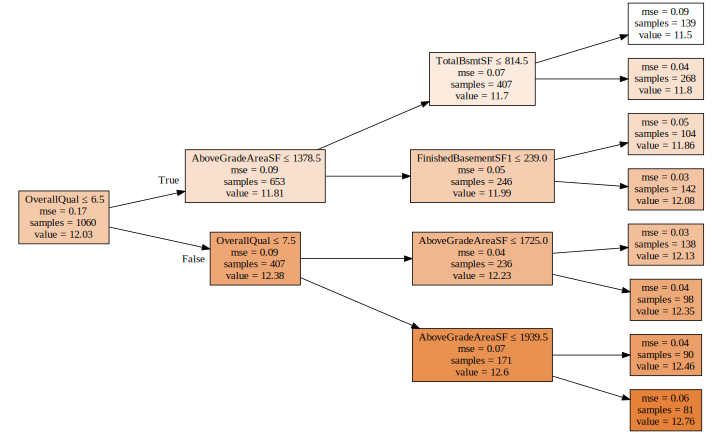

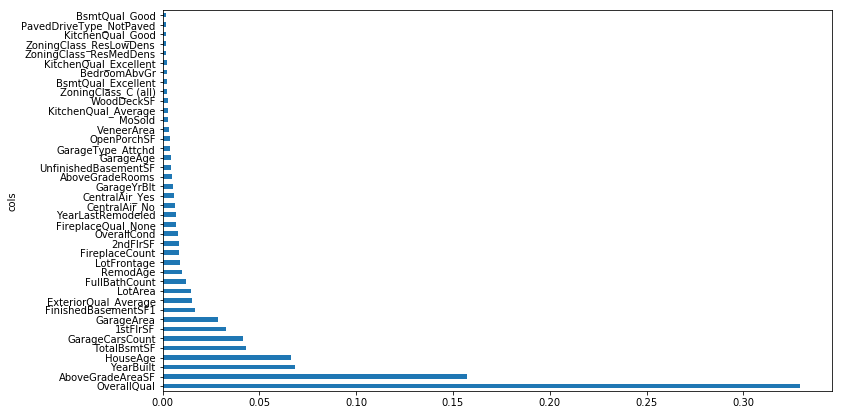

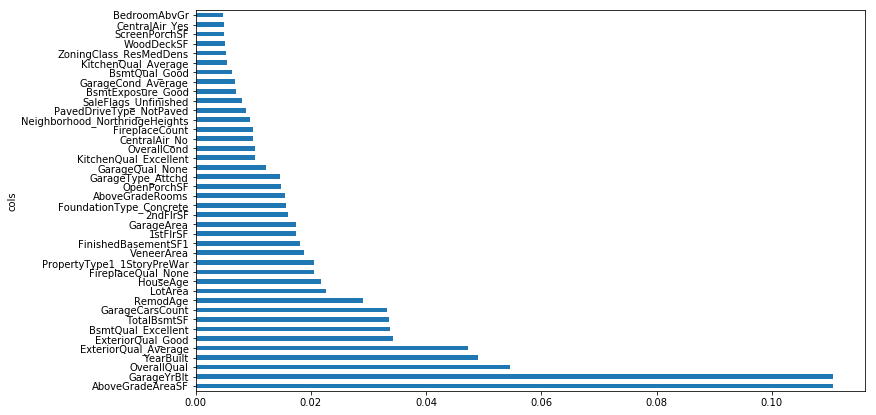

In [16]:
# Create baseline models for single decison tree, RF, ExtraTrees, GBM

dec_tree = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
print("Decision tree:")
%time dec_tree.fit(X_train, y_train)
print_score(dec_tree)
print("-----------")

rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1,min_samples_leaf=3, max_features=0.5, oob_score=True)
print("RF result:")
%time rf.fit(X_train, y_train)
print_score(rf)
print("-----------")

rf_extra = ExtraTreesRegressor(n_estimators=1000, n_jobs=-1,min_samples_leaf=5, max_features=0.5)
print("Extra trees result:")
%time rf_extra.fit(X_train, y_train)
print_score(rf_extra)
print("-----------")

gbm =  GradientBoostingRegressor(n_estimators= 1000, learning_rate = 0.1, max_features ='sqrt', min_samples_leaf= 10) #, oob_score=True)
print("GBM result:")
%time gbm.fit(X_train, y_train)
print_score(gbm)
print("-----------")

xgb = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.1,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=1) 
print("XGBoost:")
%time xgb.fit(X_train, y_train)
print_score(xgb)

# Visualise tree
draw_tree(dec_tree.estimators_[0], df, precision=2)

# Visualise feature importace for random forest
fi0 = rf_feat_importance(rf, df); fi0[:15]
plot_fi(fi0[:40])
#fi1 = rf_feat_importance(m1, df); fi[:10]

# Visualise feature importace for GBM
fi0 = rf_feat_importance(gbm, df); fi0[:15]
plot_fi(fi0[:40])
#fi1 = rf_feat_importance(m1, df); fi[:10]

# Feature correlations

27


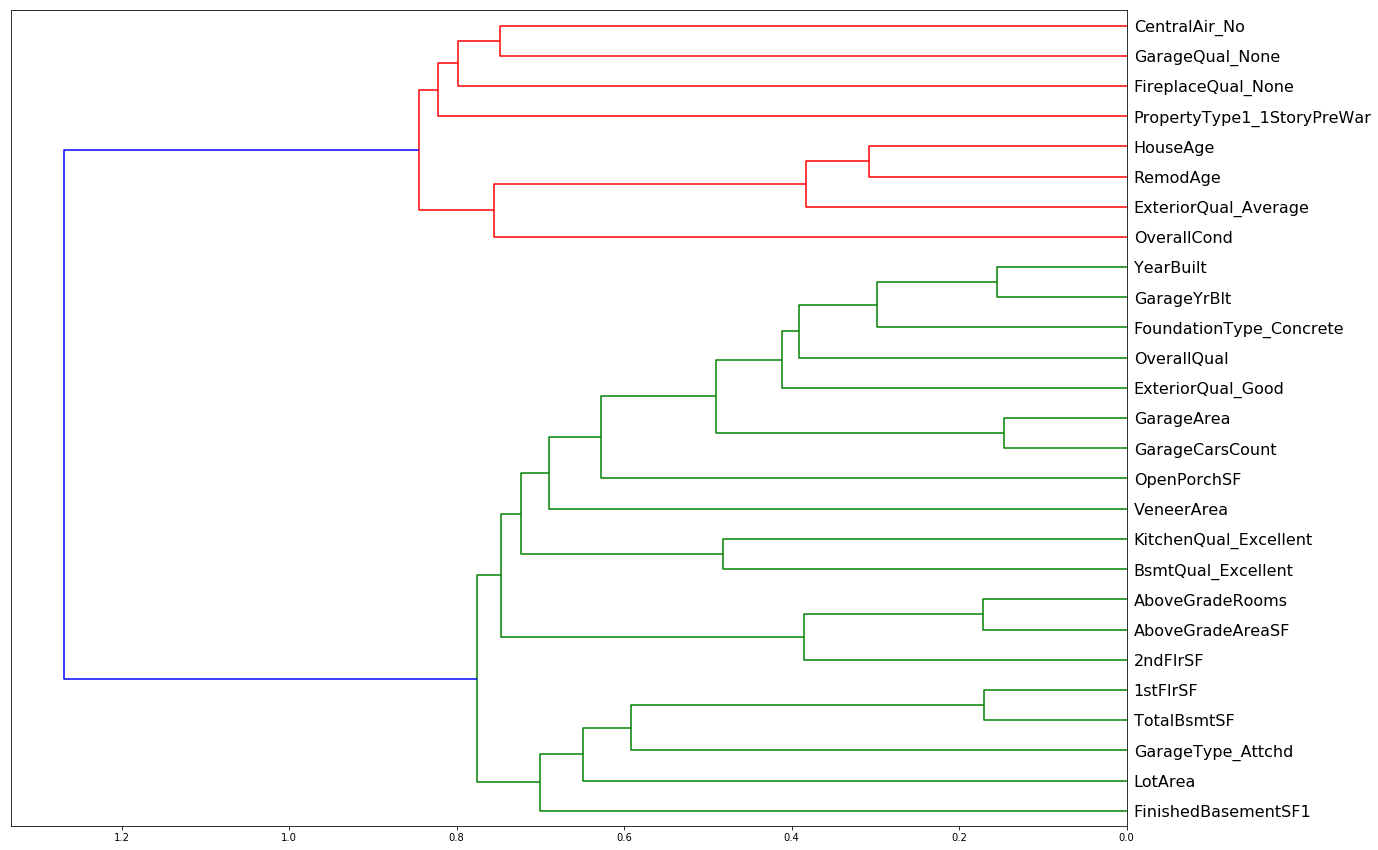

In [17]:
# Simplify to focus on most important features with > 0.5% feature importance, invetsigate correlations

to_keep = fi0[fi0.imp>0.01].cols
print(len(to_keep))
df_keep = df[to_keep].copy()

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(20,15))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

# Tree  hyperparameter tuning

In [18]:
# Grid search for extra random forest with n trees
erf =  ExtraTreesRegressor(n_estimators= 1000)

# Feature space searched
#grid_param_erf = [{'min_samples_leaf': [2,3,5,7,10,20], 'max_features' :  ['auto', 'sqrt', 'log2', 0.5, 0.2, 0.1]}]

# Best params
grid_param_erf = [{'min_samples_leaf': [2], 'max_features' :  [0.2]}]
para_search_erf = ms.GridSearchCV(estimator=erf, param_grid=grid_param_erf, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search_erf = para_search_erf.fit(df, y)
tuning_results_erf = pd.DataFrame(para_search_erf.cv_results_)
tuning_results_erf['RMSE'] = np.sqrt(abs(tuning_results_erf.mean_test_score))
tuning_results_erf.sort_values('RMSE').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,RMSE
0,6.458563,0.038291,0.149108,0.003635,0.2,2,"{'max_features': 0.2, 'min_samples_leaf': 2}",-0.016082,-0.025501,-0.02467,-0.017729,-0.020437,-0.020884,0.003711,1,-0.001528,-0.001358,-0.001352,-0.001508,-0.001527,-0.001455,0.000082,0.144512


In [19]:
# Grid search for random forest with n trees
rf =  RandomForestRegressor(n_estimators= 1000)

# Feature space searched
#grid_param_rf = [{'min_samples_leaf': [2,3,5,7,10,20], 'max_features' :  ['auto', 'sqrt', 'log2', 0.5, 0.2, 0.1]}]
#{'max_features': 0.2, 'min_samples_leaf': 2}	0.064613	0.134249

# Best params
grid_param_rf = [{'min_samples_leaf': [2], 'max_features' :  [0.2]}]
para_search_rf = ms.GridSearchCV(estimator=rf, param_grid=grid_param_rf, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search_rf = para_search_rf.fit(df, y)
tuning_results_rf = pd.DataFrame(para_search_rf.cv_results_)
tuning_results_rf['RMSE'] = np.sqrt(abs(tuning_results_rf.mean_test_score))
tuning_results_rf.sort_values('RMSE').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,RMSE
0,6.412342,0.011614,0.131881,0.002189,0.2,2,"{'max_features': 0.2, 'min_samples_leaf': 2}",-0.015916,-0.023328,-0.021121,-0.016389,-0.020433,-0.019437,0.002852,1,-0.004747,-0.004432,-0.004482,-0.004867,-0.004679,-0.004641,0.000163,0.139418


In [20]:
# Grid search for GBM
# Best params {'min_samples_leaf': 3, 'max_features' : 0.1, 'n_estimators': 1200, learning_rate: 0.03]  -> 0.114849
# Feature space searched
#grid_param_gbm = [{'min_samples_leaf': [2,3,5,7,10,20], 'max_features' : ['auto', 'sqrt', 'log2', 0.5, 0.2, 0.1], 'n_estimators': [100,1000,10000]}] 
               #'learning_rate ' : [0.001, 0.01, 0.1]}]

# Best params
gbm =  GradientBoostingRegressor()
grid_param_gbm = [{'min_samples_leaf': [3], 'max_features' : [0.1], 'n_estimators': [1750], 'learning_rate': [0.05]}]
para_search_gbm = ms.GridSearchCV(estimator=gbm, param_grid=grid_param_gbm, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search_gbm = para_search_gbm.fit(df, y)
tuning_results_gbm = pd.DataFrame(para_search_gbm.cv_results_)
tuning_results_gbm['av_RMSE'] = np.sqrt(abs(tuning_results_gbm.mean_test_score))
tuning_results_gbm['min_RMSE'] = np.sqrt(-tuning_results_gbm[['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']].min(axis=1))
tuning_results_gbm.sort_values('min_RMSE').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,av_RMSE,min_RMSE
0,2.264377,0.078808,0.025329,0.000366,0.05,0.1,3,1750,"{'learning_rate': 0.05, 'max_features': 0.1, '...",-0.011164,-0.01793,-0.015567,-0.010739,-0.015582,-0.014196,0.002789,1,-0.000838,-0.000832,-0.000807,-0.000892,-0.000868,-0.000847,0.00003,0.119148,0.133904


In [21]:
#Best params so far: colsample of 0.8,  min_child_weight =1, max_depth = 3, n_estimators = 1000, gamme = 0 -> 

# Feature space explored 
#    'colsample_bytree':[0.4,0.6,0.8], # Control overfitting
#    'min_child_weight':[1,3,6,10], # Control overfitting
#    'n_estimators': [100,1000,10000],
#    'max_depth':[3,5,7,10],
#    'gamma':[0,1,10]  # Higher values control model complexity and overfitting

param_grid_xgb = {
    'colsample_bytree':[0.8], # Control overfitting
    'min_child_weight':[1], # Control overfitting
    'n_estimators': [1000],
    'max_depth':[3],
    'gamma':[0]  # Higher values control model complexity and overfitting
}
                    
%time xgb_model = xgboost.XGBRegressor(seed=1)
para_search_xgb = ms.GridSearchCV(estimator = xgb_model, param_grid = param_grid_xgb, n_jobs=-1,iid=False, verbose=10,scoring='neg_mean_squared_error')
para_search_xgb.fit(df, y)
tuning_results_xgb = pd.DataFrame(para_search_xgb.cv_results_)
tuning_results_xgb['RMSE'] = np.sqrt(abs(tuning_results_xgb.mean_test_score))
tuning_results_xgb.sort_values('RMSE')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 48.2 µs
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.9s finished


[02:23:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,RMSE
0,9.794068,0.259421,0.050839,0.002972,0.8,0,3,1,1000,"{'colsample_bytree': 0.8, 'gamma': 0, 'max_dep...",-0.013286,-0.018812,-0.014527,-0.015542,0.002367,1,0.124667


# Ridge vs Lasso

In [22]:
#elastic_train = train.copy() # Making copy
#Xtrain_elastic, Ytrain_elastic, na_elastic = proc_df(elastic_train, 'SalePrice', max_n_cat=200) #Splitting with saleprice
#### [trainX, trainY, validX, validY, na_scale] = proc_df2(category_list = "none", df1 = train, df2 = None, y_fld = "SalePrice", n_validation = 300, percentage_validation = None, add_variables = False, imputation_methodology = "median", impute_using = "all", drop_outliers = False, log_size_variables = False, variables_to_square = None, drop_variables = False)

#y_df = pd.DataFrame(Ytrain_elastic)

#### Arbitrary removal of 300 observations for validation
#np.random.seed(1)
#validIdxes = np.random.choice(range(1460), size= 300, replace=False)
#trainIdxes = list(set(range(1460))-set(validIdxes))
#trainX = Xtrain_elastic.iloc[trainIdxes]
#validX  = Xtrain_elastic.iloc[validIdxes]
#trainY = y_df.iloc[trainIdxes]
#validY  = y_df.iloc[validIdxes]

In [23]:
ridge = Ridge()
lasso = Lasso()
net   = ElasticNet()

In [24]:
# Ridge

#ridge.set_params(normalize=True)
#ridge_scores_train = []
#ridge_scores_valid  = []

#alphas = np.linspace(1,11,50)

#for alpha in alphas:
#            ridge.set_params(alpha=alpha)
#            ridge.fit(trainX, trainY)
#            ridge_scores_train.append(ridge.score(trainX, trainY))
#            ridge_scores_valid.append(ridge.score(validX, validY))
#ridge_scores_train = np.array(ridge_scores_train) 
#ridge_scores_valid = np.array(ridge_scores_valid)

#### Ridge, training vs validation set
#plt.plot(alphas, ridge_scores_train, label=r'$train\ R^2$')
#plt.plot(alphas, ridge_scores_valid, label=r'$valid\ R^2$')
#plt.legend(loc=1)
#plt.title(r'Ridge Train-Validation $R^2$ Comparison')
#ridge_underfit = ridge_scores_valid < ridge_scores_train
#last_underfit  = np.max(alphas[ridge_underfit])
#plt.axvline(last_underfit, linestyle='--', color='g', label='optimal lambda', alpha=0.4)
#plt.legend(loc=1)
#plt.xlabel(r'hyperparameter $\lambda$')
#plt.ylabel(r'$R^2$')

In [25]:
# Lasso

#lasso.set_params(normalize=True)
#lasso_scores_train = []
#lasso_scores_valid  = []

#alphas = np.linspace(0.00001, 0.0005, 50)

#for alpha in alphas:
#            lasso.set_params(alpha=alpha)
#            lasso.fit(trainX, trainY)
#            lasso_scores_train.append(lasso.score(trainX, trainY))
#            lasso_scores_valid.append(lasso.score(validX, validY))
#lasso_scores_train = np.array(lasso_scores_train) 
#lasso_scores_valid = np.array(lasso_scores_valid)

#### Lasso training vs validation set 
#plt.plot(alphas, lasso_scores_train, label=r'$train\ R^2$')
#plt.plot(alphas, lasso_scores_valid, label=r'$valid\ R^2$')
#plt.title(r'Lasso Train-Validation $R^2$ Comparison')
#lasso_underfit = lasso_scores_valid < lasso_scores_train
#last_underfit  = np.max(alphas[lasso_underfit])
#plt.axvline(last_underfit, linestyle='--', color='g', label='optimal lambda', alpha=0.4)
#plt.legend(loc=1)
#plt.xlabel(r'hyperparameter $\lambda$')
#plt.ylabel(r'$R^2$')

Cross Validation, Lasso

In [26]:
## Finding optimum number of folds
#mean_error = []
#std_error = []
#kfold = range(3, 15)
#for i in kfold:
#    scores = ms.cross_val_score(estimator=lasso, X=Xtrain_elastic, y=Ytrain_elastic, cv=i)
#    mean_error.append(1 - scores.mean())
#    std_error.append(scores.std())

#s1 = plt.scatter(kfold, mean_error, label='mean error')
#plt.plot(kfold, mean_error)
#s2 = plt.scatter(kfold, std_error, color='red', label='std')
#plt.plot(kfold, std_error, color='red')
#plt.xlim(0, 15)
#plt.xlabel('number of fold')
#plt.legend(handles=[s1, s2], loc=2)
#plt.show()

In [27]:
# Continue with 3 folds

In [28]:
#import sklearn.model_selection as ms
#trainX, validX, trainY, validY = ms.train_test_split(Xtrain_elastic, Ytrain_elastic, 
#                                                       test_size=1.0/5, random_state=0)
#print('Original: {}, {}'.format(Xtrain_elastic.shape, Ytrain_elastic.shape))
#print('Training: {}, {}'.format(trainX.shape, trainY.shape))
#print('Test: {}, {}'.format(validX.shape, validY.shape))

In [29]:
# Finding best lambda with 3-fold CV
#lasso.set_params(normalize=True, max_iter=10000)
#alphas = np.linspace(0.00001, 0.0005, 50)
#lasso_scores_train = []
#lasso_scores_valid  = []
#score_means = []

#for alpha in alphas:
#    lasso.set_params(alpha = alpha)
#    lasso.fit(Xtrain_elastic, Ytrain_elastic)
#    scores = ms.cross_val_score(estimator=lasso, X=Xtrain_elastic, y=Ytrain_elastic, cv=3)
#    score_means.append(scores.mean())
    
#plt.plot(alphas, score_means)
#plt.title('Best Alpha with 5-fold CV')
#plt.ylabel('R^2')
#plt.xlabel('Alphas')

In [30]:
# Best Lambda of 0.0001
#lasso.set_params(alpha=0.0001, normalize=True)

#train_error = []
#test_error = []
#train_rsq = []
#test_rsq = []

#for i in range(5):
#    trainX, validX, trainY, validY = ms.train_test_split(Xtrain_elastic, Ytrain_elastic, test_size=1.0/3, random_state=i)
#    lasso.fit(trainX, trainY)
#    train_error.append(1 - lasso.score(trainX, trainY))
#    test_error.append(1 - lasso.score(validX, validY))
#    train_rsq.append(lasso.score(trainX, trainY))
#    test_rsq.append(lasso.score(validX, validY))

In [31]:
#print('Training Error: {}'.format(np.round(np.array(train_error), 4))) # training error
#print('Test Error: {}'.format(np.round(np.array(test_error), 4))) # test error
#print('Training R Squared: {}'.format(np.round(np.array(train_rsq), 4)))
#print('Test R Squared: {}'.format(np.round(np.array(test_rsq), 4)))

## calculating the mean of the test error
#print('Test Error Mean: {:6f}'.format(np.mean(test_error)))

## calculating the standard deviation of the test errors
#print('Test Error SD: {:6f}'.format(np.std(test_error)))

## calculating test r squared
#print('Mean R Squared: {:6f}'.format(np.mean(test_rsq)))

In [32]:
# RMSE with Lasso and lambda 0.0001
#y = lasso.predict(Xtrain_elastic)
#ydf = pd.DataFrame(y)
#rmse(ydf, pd.DataFrame(Ytrain_elastic))

In [33]:
# Finding lasso coefficients with alpha 0.0001
#lasso.set_params(alpha=0.0001, normalize=True)
#lasso.fit(Xtrain_elastic, Ytrain_elastic)

#coefs_lasso  = []

#coefs_lasso = lasso.coef_
#coefs_lasso = pd.DataFrame(coefs_lasso, index = Xtrain_elastic.columns)
#coefs_lasso.columns = ['Coefficient']
#coefs_lasso = coefs_lasso.sort_values(by = 'Coefficient', ascending=False)
#coefs_lasso

In [34]:
#coefs_lasso.index

In [35]:
# Variables that lasso removes
#len(coefs_lasso[coefs_lasso['Coefficient']==0])

In [36]:
# Variables lasso keeps
#len(coefs_lasso[coefs_lasso['Coefficient']!=0])

# Elastic Net

In [37]:
# Elastic net with cv 3, lambda 0.00035 - 0.0004, rho 0.85 - 0.95
#N_alpha = 2
#N_rho   = 11
#alphaRange = np.linspace(0.00035, 0.0004, N_alpha)
#rhoRange   = np.linspace(0.85,0.95, N_rho)
#scores     = np.zeros((N_rho, N_alpha))
#for alphaIdx, alpha in enumerate(alphaRange):
#    for rhoIdx, rho in enumerate(rhoRange):
#            net.set_params(alpha=alpha, l1_ratio=rho, max_iter=1000)
#            net.fit(Xtrain_elastic, Ytrain_elastic)
#            score = ms.cross_val_score(estimator=net, X=Xtrain_elastic, y=Ytrain_elastic, cv=3).mean()
#            scores[rhoIdx, alphaIdx] = score

In [38]:
#rhoRange

In [39]:
#alphaRange

In [40]:
#scores

In [41]:
#grid_df = pd.DataFrame(scores, columns = [alphaRange], index = [rhoRange])
#grid_df

In [42]:
# Move forward with alpha as 0.0004 and rho as 0.91

In [43]:
#net.set_params(alpha=0.0004, l1_ratio=0.91, normalize=False, max_iter=30000)
#net.fit(Xtrain_elastic, Ytrain_elastic)
#cv_scores = ms.cross_val_score(estimator=net, X=Xtrain_elastic, y=Ytrain_elastic, cv=3)
#cv_scores.mean()

In [44]:
# RMSE with Net and lambda 0.0004, Rho 0.91, cv 3
#y = net.predict(Xtrain_elastic)
#ydf = pd.DataFrame(y, )
#rmse(ydf, pd.DataFrame(Ytrain_elastic))

In [45]:
#zdf = pd.DataFrame(Ytrain_elastic)

In [46]:
#mean_squared_error = mse(ydf, zdf)
#mean_squared_error

In [47]:
#squared_error = se(ydf, zdf)
#squared_error.columns = ['Squared Error']
#squared_error['Above Average'] = squared_error['Squared Error'].apply(lambda x: 1 if x > 0.010669 else 0) 
#squared_error.columns = ['Squared Error', 'Above Average']
#squared_error.index = squared_error.index+1
# Biggest offenders on Squared Error with elastic net model
#squared_error.sort_values(by='Squared Error', ascending=False).head()

In [48]:
#plt.hist(squared_error[squared_error['Squared Error']<0.1]['Squared Error'], bins=100)
#plt.title('Distribution of squared error with elastic net model')

In [49]:
# Proportion of data set which has a squared error greater than the average.
#len(squared_error[squared_error['Squared Error']>0.011356])/len(squared_error['Squared Error'])

In [50]:
# add column to training set with 'above average' which matches on index
#error_search_df = Xtrain_elastic.copy()

In [51]:
#new_df = error_search_df.merge(squared_error, how='outer', left_index=True, right_index=True)
#new_df.head()

In [52]:
#plt.scatter(x = new_df.YearBuilt, y=new_df['Squared Error'], c=new_df['Above Average'], alpha = 0.3)

In [53]:
#plt.scatter(x = new_df.LotArea, y=new_df['Squared Error'], c=new_df['Above Average'], alpha = 0.3)

In [54]:
#plt.scatter(x = new_df.LotFrontage, y=new_df['Squared Error'], c=new_df['Above Average'], alpha = 0.3)

In [55]:
#len(squared_error[squared_error['Squared Error']>0.05])/len(squared_error['Squared Error'])

In [56]:
# Looking for clustering within variables where the top 2.8 percentile of Squared Error
#import seaborn as sns
#column_list = Xtrain_elastic.columns.to_list()
#pp = sns.pairplot(data=new_df[new_df['Squared Error']>0.05],
#                  x_vars=['Squared Error'],
#                  y_vars=column_list[0:40])

**Lasso with Proc DF2**

Dropping 5 SD Outliers...
Comprehensively dropping variables.


Text(0.5, 0, 'Alphas')

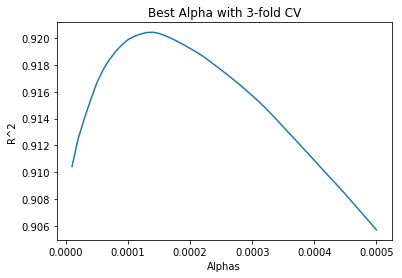

In [57]:
# One version of Processed Data Frame with following characteristics:

[x, y, nas] = proc_df2(vars_to_cat="none",
                        df1 = train,
                        df2 = None,
                        y_fld = "SalePrice",
                        n_validation=None,
                        add_variables=True,
                        imputation_methodology="mean",
                        impute_using="train",
                        drop_outliers="5SD",
                        log_size_variables=True,
                        square_variables = True,
                        drop_variables="comprehensive")                                             


# Finding best lambda with 3-fold CV

lasso.set_params(normalize=True, max_iter=10000)
alphas = np.linspace(0.00001, 0.0005, 50)
lasso_scores_train = []
lasso_scores_valid  = []
score_means = []

for alpha in alphas:
    lasso.set_params(alpha = alpha)
    lasso.fit(x, y)
    scores = ms.cross_val_score(estimator=lasso, X=x, y=y, cv=3)
    score_means.append(scores.mean())
    
plt.plot(alphas, score_means)
plt.title('Best Alpha with 3-fold CV')
plt.ylabel('R^2')
plt.xlabel('Alphas')

In [58]:
# Search for best alpha with a grid search

[x, y, nas] = proc_df2(vars_to_cat="none",
            df1 = train,
            df2 = None,
            y_fld = "SalePrice",
            n_validation=None,
            add_variables=True,
            imputation_methodology="mean",
            impute_using="train",
            drop_outliers="5SD",
            log_size_variables=True,
            square_variables = True,
            drop_variables="comprehensive")

# Grid search for best alpha

lasso.set_params(normalize=True)
lasso.fit(x, y)

grid_param_lasso = [{'alpha': np.linspace(0.00005, 0.00015, 30)}]

para_search_lasso = ms.GridSearchCV(estimator=lasso, param_grid=grid_param_lasso, scoring='neg_mean_squared_error', cv=3, return_train_score=True)
#para_search_lasso = ms.GridSearchCV(estimator=lasso, param_grid=grid_param_lasso, scoring='r2', cv=3, return_train_score=True)
para_search_lasso = para_search_lasso.fit(x, y)
tuning_results_lasso = pd.DataFrame(para_search_lasso.cv_results_)
tuning_results_lasso.sort_values('rank_test_score').head()

# 0.000135 best alpha
# 0.92 mean_r^2
# 0.11 root mean sq error

Dropping 5 SD Outliers...
Comprehensively dropping variables.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
25,0.126389,0.101685,0.002153,0.000031,0.000136207,{'alpha': 0.00013620689655172413},-0.011650,-0.014401,-0.011812,-0.012621,0.001260,1,-0.010529,-0.009674,-0.010663,-0.010289,0.000438
24,0.132390,0.109087,0.002107,0.000086,0.000132759,{'alpha': 0.00013275862068965518},-0.011661,-0.014397,-0.011810,-0.012623,0.001256,2,-0.010487,-0.009637,-0.010622,-0.010249,0.000436
26,0.119091,0.096172,0.002017,0.000137,0.000139655,{'alpha': 0.0001396551724137931},-0.011653,-0.014406,-0.011814,-0.012624,0.001261,3,-0.010569,-0.009711,-0.010703,-0.010328,0.000440
27,0.117391,0.095791,0.002148,0.000265,0.000143103,{'alpha': 0.00014310344827586207},-0.011656,-0.014412,-0.011818,-0.012629,0.001263,4,-0.010609,-0.009748,-0.010743,-0.010367,0.000441
23,0.134534,0.111112,0.002113,0.000207,0.00012931,{'alpha': 0.0001293103448275862},-0.011683,-0.014395,-0.011811,-0.012629,0.001249,5,-0.010442,-0.009600,-0.010580,-0.010208,0.000433


In [59]:
# Lasso coefficients for this df:

[x, y, nas] = proc_df2(vars_to_cat="none",
                        df1 = train,
                        df2 = None,
                        y_fld = "SalePrice",
                        n_validation=None,
                        add_variables=True,
                        imputation_methodology="mean",
                        impute_using="train",
                        drop_outliers="5SD",
                        log_size_variables=True,
                        square_variables = True,
                        drop_variables="comprehensive")

# set best alpha with this df
lasso.set_params(alpha=0.000135714, normalize=True)
lasso.fit(x, y)

coefs_lasso  = []

coefs_lasso = lasso.coef_
coefs_lasso = pd.DataFrame(coefs_lasso, index = x.columns)
coefs_lasso.columns = ['Coefficient']
coefs_lasso = coefs_lasso.sort_values(by = 'Coefficient', ascending=False)
coefs_lasso



Dropping 5 SD Outliers...
Comprehensively dropping variables.


,Coefficient
Residential,0.250435
LotArea_logged,0.063895
OverallQual,0.053402
Neigh1,0.051229
Average_Score,0.040312
...,...
Depression_Price_Flags,-0.052421
Moderate_Defects,-0.060236
Major_Defects,-0.091558
Exterior_CommonBrickProportion,-0.144259


In [60]:
# Proportion of variables it keeps:
len(coefs_lasso[coefs_lasso['Coefficient']>=0])/(len(coefs_lasso[coefs_lasso['Coefficient']==0] + len(coefs_lasso[coefs_lasso['Coefficient']>=0])))

1.2536231884057971

# Model stacking - fitting residuals

In [61]:
#RF on RESIDUALS

# Encode lasso data
[x_train_lasso, y_train_lasso, x_test_lasso, y_test_lasso, nas] = proc_df2(vars_to_cat="none",df1 = train,df2 = test,y_fld = "SalePrice",
                                                                            n_validation=None,add_variables=True,imputation_methodology="median",impute_using="train",
                                                                            drop_outliers="5SD",log_size_variables=True,square_variables = False,drop_variables=False)

lasso.set_params(alpha=0.00015, normalize=True)
lasso.fit(x_train_lasso, y_train_lasso)

lasso_results = pd.DataFrame(x_train_lasso.index, columns = ['Id'])
lasso_results['lasso_pred'] = lasso.predict(x_train_lasso)
lasso_results['actuals'] = y_train_lasso
lasso_results['residuals'] = lasso_results.actuals - lasso_results.lasso_pred
lasso_results.set_index('Id',inplace=True)

# Encode RF data, need to drop outliers with ordinal/minimal features
[x_train_rf, y_train_rf, x_test_rf, y_test_rf, nas_rf] = proc_df2(vars_to_cat="ordinal",df1 = train,df2 = test,y_fld = "SalePrice",
                                                    n_validation=None,add_variables=True,imputation_methodology="mean",impute_using="train",
                                                    drop_outliers=False,log_size_variables=False,square_variables = False,drop_variables="minimal")

Dropping 5 SD Outliers...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:152: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Not dropping variables.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:152: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Minimally dropping variables.


In [62]:
# Set up datasets for residual training, allowing for lasso prediction to be a feature in the estimation
y_train_rf = np.array(lasso_results["residuals"]).ravel()
x_train_rf = pd.merge(lasso_results,x_train_rf, left_index = True, right_index = True, how='left').drop(['actuals','residuals'],axis=1)
X_train = x_train_rf
y_train = np.array(y_train_rf).ravel()

In [63]:
# Grid search for extra random forest with 1000 trees
rf =  RandomForestRegressor(n_estimators= 200)

# Feature space searched
# grid_param_rf = [{'min_samples_leaf': [2,3,5,7,10,15,20], 'max_features' :  [0.2,0.1, 0.075, 'sqrt', 0.02]}]

# Best params
grid_param_rf = [{'min_samples_leaf': [7], 'max_features' :  [0.2]}]
para_search_rf = ms.GridSearchCV(estimator=rf, param_grid=grid_param_rf, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search_rf = para_search_rf.fit(X_train, y_train)
tuning_results_rf = pd.DataFrame(para_search_rf.cv_results_)
tuning_results_rf['RMSE'] = np.sqrt(abs(tuning_results_rf.mean_test_score))
tuning_results_rf['min_RMSE'] = np.sqrt(-tuning_results_rf[['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']].min(axis=1))
tuning_results_rf.sort_values('RMSE').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,RMSE,min_RMSE
0,1.307179,0.017008,0.023135,0.001687,0.2,7,"{'max_features': 0.2, 'min_samples_leaf': 7}",-0.009129,-0.010148,-0.011743,-0.008726,-0.009536,-0.009856,0.001053,1,-0.00587,-0.005674,-0.005396,-0.005925,-0.005738,-0.005721,0.000185,0.099278,0.108366


In [64]:
# Grid search for extra random forest with 1000 trees
#grid_param_erf = [{'min_samples_leaf': [2,3,5,7,10,15,20], 'max_features' :  [0.2,0.1, 0.075, 'sqrt', 0.02]}]

# Best params
grid_param_erf = [{'min_samples_leaf': [7], 'max_features' :  [0.2]}]
erf = ExtraTreesRegressor(n_estimators= 500)
para_search_erf = ms.GridSearchCV(estimator=erf, param_grid=grid_param_erf, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search_erf = para_search_erf.fit(X_train, y_train)
tuning_results_erf = pd.DataFrame(para_search_erf.cv_results_)
tuning_results_erf['RMSE'] = np.sqrt(abs(tuning_results_erf.mean_test_score))
tuning_results_erf['min_RMSE'] = np.sqrt(-tuning_results_erf[['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score']].min(axis=1))
tuning_results_erf.sort_values('RMSE').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,RMSE,min_RMSE
0,2.49058,0.076748,0.057175,0.000896,0.2,7,"{'max_features': 0.2, 'min_samples_leaf': 7}",-0.009455,-0.010267,-0.012078,-0.008884,-0.009359,-0.010008,0.001126,1,-0.005393,-0.005211,-0.004921,-0.005443,-0.005265,-0.005247,0.000183,0.100041,0.109899


CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 108 ms


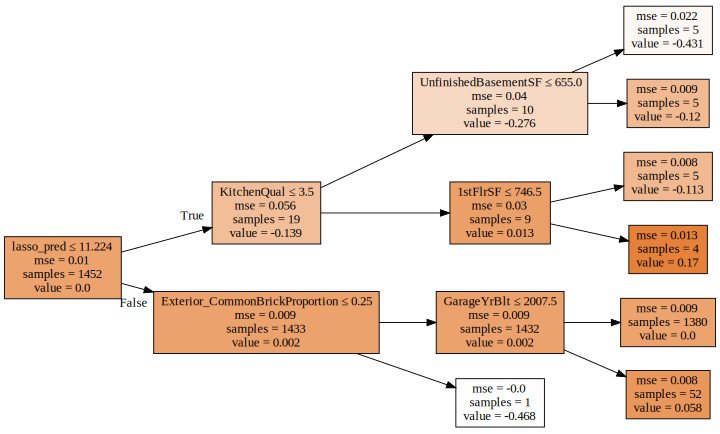

In [65]:
# Simple decision tree visualisation

dec_tree_resi = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
%time dec_tree_resi.fit(X_train, y_train)
draw_tree(dec_tree_resi.estimators_[0], X_train, precision=3)

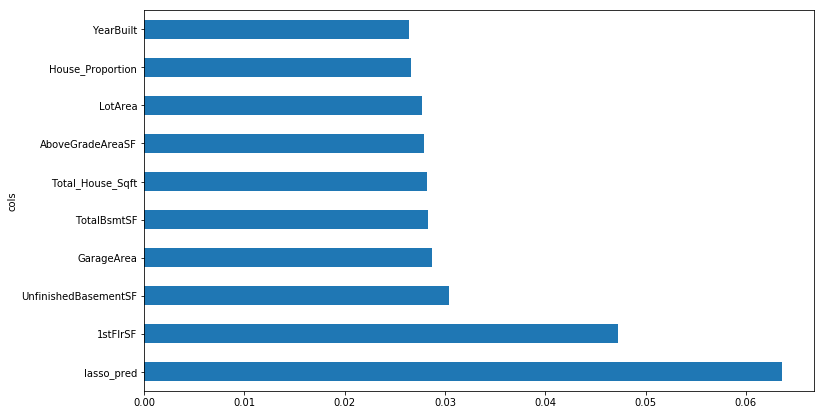

In [66]:
# Visualise feature importace for random forest

final_rf = RandomForestRegressor(n_estimators=10000, n_jobs=-1,min_samples_leaf=7, max_features=0.2, oob_score=True)
final_rf.fit(X_train, y_train)
#print_score(erf)
final_rf.feature_importances_
fi2 = rf_feat_importance(final_rf, X_train);
plot_fi(fi2[:10])

In [67]:
# Define manual cross vaildation to optimise dampening parameter across i folds

i=0
while i<2: #Three fold validation
    rand_shared = round(1000*random())
    X_tr_lasso, X_val_lasso, y_tr_lasso, y_val_lasso = ms.train_test_split(x_train_lasso, y_train_lasso, test_size=0.2, random_state=rand_shared)
   # tr_ids = pd.DataFrame(X_tr_lasso.index, columns = ['Id']).set_index('Id')
   
    lasso_tr = pd.DataFrame(X_tr_lasso.index, columns = ['Id'])
    lasso_tr['lasso_pred'] = lasso.predict(X_tr_lasso)
    lasso_tr.set_index('Id',inplace=True)
    X_train_rf = pd.merge(lasso_tr,x_train_rf, left_index = True, right_index = True)
    
    lasso_val = pd.DataFrame(X_val_lasso.index, columns = ['Id'])
#    lasso_val['lasso_pred'] = lasso.predict(X_val_lasso)
    lasso_val.set_index('Id',inplace=True)
    X_val_rf = pd.merge(lasso_val,x_train_rf, left_index = True, right_index = True)
  

    for adj_weight in np.linspace(0, 5, 11):
        comb_predict = lasso.predict(X_val_lasso) + adj_weight * final_rf.predict(X_val_rf)
        print(adj_weight, math.sqrt(((comb_predict-y_val_lasso)**2).mean()))
    i +=1

0.0 0.1091641299437824
0.5 0.09515547113705859
1.0 0.08224998490770981
1.5 0.0710513635083222
2.0 0.062484177233403014
2.5 0.057732040166178375
3.0 0.057744648479608036
3.5 0.06251911950266169
4.0 0.07110257441058679
4.5 0.08231191761408736
5.0 0.0952243003853214
0.0 0.11148256898283679
0.5 0.09724448339319536
1.0 0.08410085110734569
1.5 0.07264815212188436
2.0 0.0638035430022737
2.5 0.05875685011754409
3.0 0.05849940183456689
3.5 0.06308985526566639
4.0 0.07160179399328877
4.5 0.08283502406498124
5.0 0.09583737665341575


# Final Kaggle submission

In [68]:
# Residual weighting set to 1 
adj_weight = 1

test_predictions = pd.DataFrame(x_test_lasso.index, columns = ['Id'])
test_predictions['lasso_pred'] = lasso.predict(x_test_lasso)
test_predictions.set_index('Id',inplace=True)
x_test_rf = pd.merge(test_predictions,x_test_rf, left_index = True, right_index = True, how='left')
test_predictions["RF_adjustments"] = final_rf.predict(x_test_rf) #RF adjustments
test_predictions["final_estimate"] = test_predictions["lasso_pred"] + adj_weight * test_predictions["RF_adjustments"]
test_predictions["SalePrice"] = np.exp(test_predictions["final_estimate"].astype("float"))
test_predictions.reset_index(inplace=True)

# Check output distibrution looks sensible
print("Train actuals:", pd.DataFrame(np.exp(y_train_lasso)).describe())
print("Test predictions:",test_predictions.SalePrice.describe())

# Final submission 
test_submission = test_predictions[['Id','SalePrice']]
test_submission.to_csv('submission.csv', index=False)

Train actuals:                    0
count    1452.000000
mean   180376.891185
std     79068.087698
min     34900.000000
25%    129900.000000
50%    162900.000000
75%    213492.500000
max    755000.000000
Test predictions: count    1.459000e+03
mean     1.791700e+05
std      8.433679e+04
min      4.126351e+04
25%      1.275183e+05
50%      1.564828e+05
75%      2.102604e+05
max      1.425244e+06
Name: SalePrice, dtype: float64
